In [1]:
import pandas as pd
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
patients = pd.read_csv('ExamplePats.csv')
# "pnr", "eksd", "perday", "ATC", "dur_original"
patients.rename(columns={'Unnamed: 0': 'pnr', 'DATE': 'eksd', 'PERDAY': 'perday', 'CATEGORY': 'ATC', 'DURATION': 'dur_original'}, inplace=True)
patients.head()

,pnr,PATIENT_ID,eksd,perday,ATC,dur_original
0,286,1,04/26/2033,4,medA,50
1,287,1,07/04/2033,4,medB,30
2,288,1,08/03/2033,4,medB,30
3,289,1,08/17/2033,4,medB,30
4,291,1,10/13/2033,4,medB,30


In [2]:
data = pd.read_excel('retail/Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Data preprocessing
def preprocess_retail_data(df):
    df = df.copy()
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
    df = df.sort_values(['CustomerID', 'InvoiceDate'])
    return df

In [4]:

# Modified SEE function for retail analysis
def retail_see(arg_stockcode, df):
    # Filter by stock code
    product_df = df[df['StockCode'] == arg_stockcode].copy()
    
    if product_df.empty:
        print(f"No data found for stock code: {arg_stockcode}")
        return pd.DataFrame()
    
    # Calculate purchase intervals
    product_df['prev_invoice'] = product_df.groupby('CustomerID')['InvoiceDate'].shift(1)
    product_df = product_df.dropna(subset=['prev_invoice'])
    
    # Calculate time between purchases
    product_df['purchase_interval'] = (product_df['InvoiceDate'] - product_df['prev_invoice']).dt.days
    
    # Remove single-purchase customers
    product_df = product_df.groupby('CustomerID').filter(lambda x: len(x) > 1)
    
    return product_df

In [5]:

def analyze_purchase_patterns(product_df):
    if product_df.empty:
        return None, None

    # Data cleaning: Ensure purchase_interval is positive
    min_interval = 0.1  # Minimum interval allowed (adjust as needed)
    product_df['purchase_interval'] = product_df['purchase_interval'].clip(lower=min_interval) #Clip lower values to prevent this.

    # ECDF calculation
    ecdf = ECDF(product_df['purchase_interval'])
    ecdf_df = pd.DataFrame({'days': ecdf.x, 'probability': ecdf.y})

    # Cluster determination
    X = ecdf_df[['days']].values
    print("Values in X before clustering:")  # Debugging
    X[0] = [0]
    max_clusters = min(10, len(X) - 1)

    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') #Setting n_init helps with convergence
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    optimal_k = np.argmax(silhouette_scores) + 2

    # Final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init = 'auto') #Setting n_init helps with convergence
    ecdf_df['cluster'] = kmeans.fit_predict(X)

    return ecdf_df, optimal_k

In [6]:

# Visualization function
def plot_purchase_analysis(product_df, ecdf_df, clusters):
    plt.figure(figsize=(15, 5))
    
    # Purchase intervals distribution
    plt.subplot(1, 3, 1)
    sns.histplot(product_df['purchase_interval'], bins=30, kde=True)
    plt.title('Purchase Interval Distribution')
    
    # ECDF plot
    plt.subplot(1, 3, 2)
    plt.step(ecdf_df['days'], ecdf_df['probability'], where='post')
    plt.title('Empirical Cumulative Distribution')
    
    # Cluster visualization
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='days', y='probability', hue='cluster', data=ecdf_df, palette='viridis')
    plt.title(f'Purchase Pattern Clusters (k={clusters})')
    
    plt.tight_layout()
    plt.show()

Values in X before clustering:


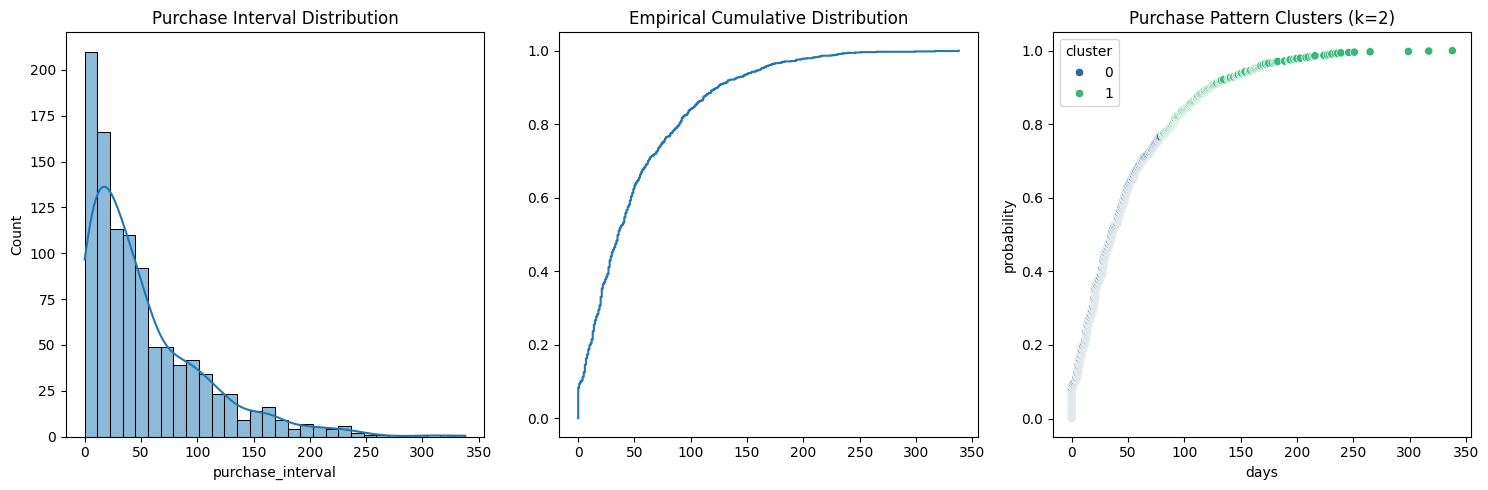

Identified 2 purchase pattern clusters
Cluster characteristics:
         count        mean        std   min   25%    50%    75%    max
cluster                                                               
0        791.0        -inf        NaN  -inf  10.0   25.0   44.0   79.0
1        241.0  130.688797  46.578592  81.0  96.0  115.0  154.0  338.0


d:\anaconda\envs\cs-3202\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [7]:
# Pipeline execution
tidy = preprocess_retail_data(data)
product_data = retail_see('85123A', tidy)  # Analyze specific product

if not product_data.empty:
    ecdf_results, cluster_count = analyze_purchase_patterns(product_data)
    
    if ecdf_results is not None:
        plot_purchase_analysis(product_data, ecdf_results, cluster_count)
        print(f"Identified {cluster_count} purchase pattern clusters")
        print("Cluster characteristics:")
        print(ecdf_results.groupby('cluster')['days'].describe())
